In [1]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans
import morph_geom_lib as mgl

from models.shallow_water_solver import shallow_water_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex


%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background'])

Z: 87
0.026165413533834583


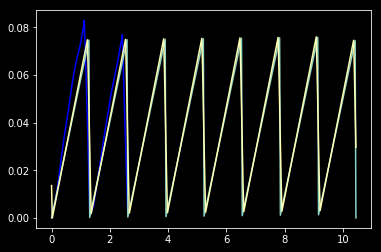

In [58]:
profile_folder = '/pymorph/notebooks/Paper_3/flume_profile_smoothed_v002.txt'
xc, z0 = mgl.readQueensFlume(profile_folder,1)

plt.plot(xc,z0,'b')

dunes = 8

xsaw = np.linspace(0, 1, 400)

zsaw = 0.076*(signal.sawtooth(2*dunes*np.pi * xsaw) + 1.)/2
xsaw = xsaw*xc.max()*dunes*0.5
plt.plot(xsaw,zsaw)


dx = xsaw[1]-xsaw[0]
znew, iterations1 = avalanche_model(dx,xsaw, zsaw, adjustment_angle=28.)
# Now flip it to run in reverse
zflip = np.flip(znew, axis=0)
zflip, iterations1 = avalanche_model(dx,xsaw, zflip, adjustment_angle=28.)
znew = np.flip(zflip, axis=0)

znew = (znew - np.min(znew))/np.ptp(znew)
znew = znew*0.076

plt.plot(xsaw,znew)
print(dx)


In [59]:


zc = znew
xc = xsaw

nx = len(xc)
# 32 cm Case 
Qc132 = 0.045
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

nP=0.4
Slope = 1.26/1000 # Based on table 4.1 in Wiebe
mannings = 0.0248
beta = 0.01

#sws.set_boundary_conditions()
Slope = 1.26/1000 # Based on table 4.1 in Wiebe
hout = 0.357
Qin = q32cm

# Sediment properties
D50 = 0.001     # Particle Diameter
rho_particule = 2650

#--------------------------------
# Initialize the sed transport 
#--------------------------------    
# Eq 57
nx = len(xc)
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
flux = np.zeros(nx)

# Sediment properties
D50 = 0.001     # Particle Diameter
rho_particule = 2650


#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 5*60 # Runtime in seconds
dt = 0.25 # Time step size (s)
extractionInterval = 60.*1
nt = int(simTime/dt)  # Number of time steps


#--------------------------------
# Set up the model reporting parameters

z0 = zc.copy() 
z600 = zc.copy() 
z2000 = zc.copy()
verts = []

tsteps=[]
iterations = 0
cntr=0

#sws.set_boundary_conditions()
surf = 0.357
Qin = q32cm

#--------------------------------
#  Run the model
#--------------------------------
for n in range(1,nt):  
    zn = zc.copy() 
    for i in range(0,nx): #i=2
        zloc = get_stencil(zn,i-2,i+4)        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc)!=6:
            raise ValueError('Stencil is incorrect')
 
        # Determine the Upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out
    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        zc[i] = zn[i]-(1./(1.-nP))*dt/dx*(floc[1]-floc[0])
    
    bed_max_delta = np.max(np.abs(zn - zc))
    
    # Apply the avalanche model
    zc, iterations1 = avalanche_model(dx,xc, zc, adjustment_angle=28.)
    # Now flip it to run in reverse
    zflip = np.flip(zc, axis=0)
    zflip, iterations1 = avalanche_model(dx,xc, zflip, adjustment_angle=28.)
    zc = np.flip(zflip, axis=0)
    
    if 1==2:
        # ----------------------------------
        # Apply the two-step smooting scheme Eq. 6 in Niemann et al 2011.
        # ----------------------------------
        zhat = np.zeros(nx)
        for i in range(0, nx):  # i=2
            zlocal = get_stencil(zc, i - 1, i + 2)
            zhat[i] = 0.5*zlocal[1] + 0.25*(zlocal[0]+zlocal[2])

        for i in range(0, nx):
            zhatlocal = get_stencil(zhat, i - 1, i + 2)
            zc[i] = (3./2.)*zhatlocal[1] - 0.25*(zhatlocal[0]+zhatlocal[2])
      
        
    slope = np.gradient(zc,dx)
    

    
    for i in range(0,nx): #i=2 
        a = 0.001
        b=3.0
        u = Qin/(surf-zc[i])
        qbedload[i] = a *u**b
        
        
        
        '''qbedload[i] = sedtrans.get_unit_bed_load_slope_shear(tau[i],D50,slope[i], 
                                                       rho_particule, 
                                                       angleReposeDegrees = 30.0, 
                                                       type='bagnold',
                                                        useSlopeAdjust=False)'''
    

    #qbedloadf = savgol_filter(qbedload, 15, 1)
    if (n*dt / extractionInterval) == math.floor(n*dt / extractionInterval):
        verts.append(list(zip(xc.copy(),zc.copy())))
        tsteps.append(n*dt)        
        np.save('flume_dunes', verts)
    
    cntr += 1
    if cntr == extractionInterval:
        cntr = 0
        print('Time step {0} of {1} - bed_max_delta {2}'.format(n,nt,bed_max_delta))    
        
print('Done')

Time step 60 of 1200 - bed_max_delta 0.000543046355900488
Time step 120 of 1200 - bed_max_delta 0.0006178039838401483
Time step 180 of 1200 - bed_max_delta 0.0006197611599997113
Time step 240 of 1200 - bed_max_delta 0.0005444359205582297
Time step 300 of 1200 - bed_max_delta 0.0005961961660387316
Time step 360 of 1200 - bed_max_delta 0.0005952943315654657
Time step 420 of 1200 - bed_max_delta 0.0005347789940325504
Time step 480 of 1200 - bed_max_delta 0.0005615883410898109
Time step 540 of 1200 - bed_max_delta 0.0005688226420873868
Time step 600 of 1200 - bed_max_delta 0.0005381885150038887
Time step 660 of 1200 - bed_max_delta 0.0005543527781334406
Time step 720 of 1200 - bed_max_delta 0.0005521587916260604
Time step 780 of 1200 - bed_max_delta 0.0005417699580493804
Time step 840 of 1200 - bed_max_delta 0.0005479337714980395
Time step 900 of 1200 - bed_max_delta 0.0005331774880480422
Time step 960 of 1200 - bed_max_delta 0.0005369715246427986
Time step 1020 of 1200 - bed_max_delta 0.0

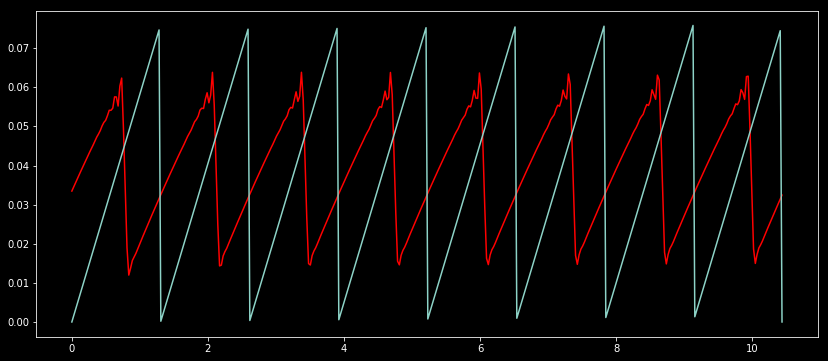

In [60]:
fig = plt.figure(figsize=(14, 6))

plt.plot(xc,zc,'r')
plt.plot(xsaw,zsaw)


Text(0.5, 0, '$x(m)$')

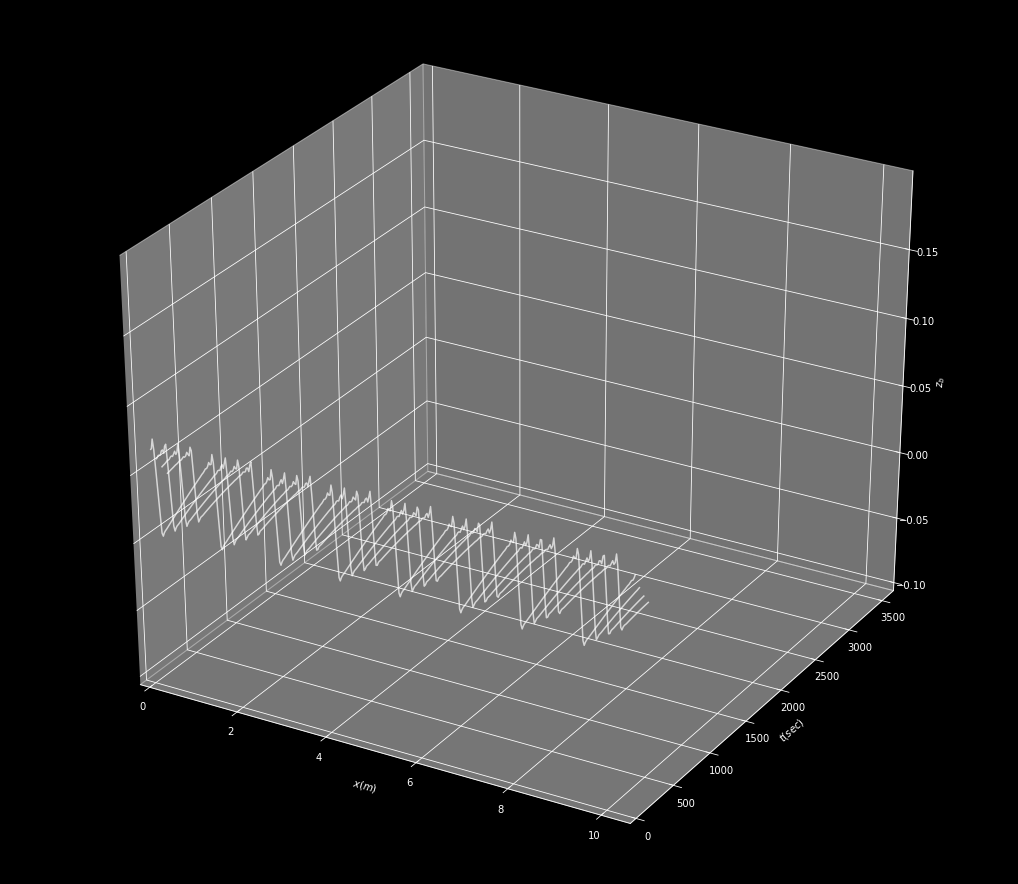

In [52]:
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D




lines = LineCollection(verts)
fig = plt.figure(figsize=(18, 16))
ax = fig.gca(projection='3d')
lines.set_alpha(0.7)
ax.add_collection3d(lines, zs=tsteps, zdir='y')
ax.set_xlim3d(0, dunes*2.6*0.5)
ax.set_zlim3d(-0.1, .2)
ax.set_ylim3d(0, 3600)
ax.set_zlabel('$z_b$')
ax.set_ylabel('$t(sec)$')
ax.set_xlabel('$x(m)$')

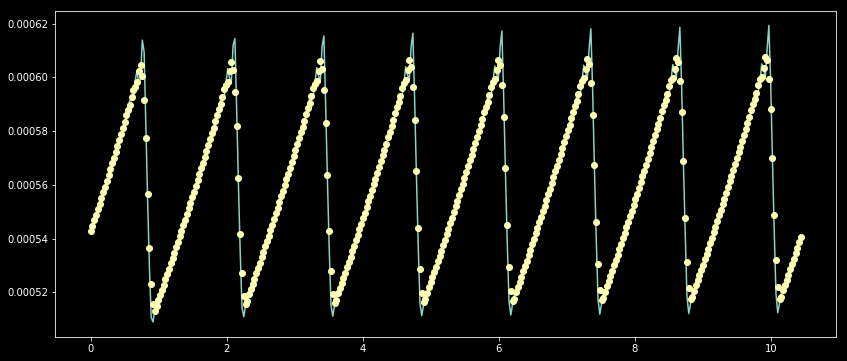

In [57]:
fig = plt.figure(figsize=(14, 6))
plt.plot(xc,qbedload)
from scipy.signal import savgol_filter
qbedloadf = savgol_filter(qbedload, 5, 1)

plt.plot(xc,qbedloadf,'o')

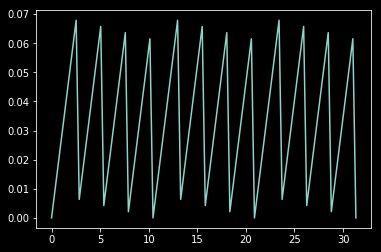

In [79]:
from scipy import signal
x = np.linspace(0, 1, 100)
z = 0.07*(signal.sawtooth(24*np.pi * x) + 1.)/2
xc = x*xc.max()*3
plt.plot(xc, z,'-')

Z: 87


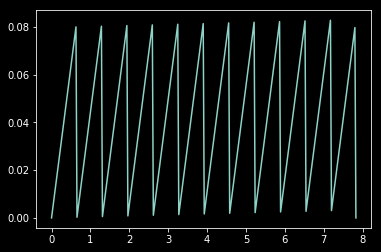

In [80]:
profile_folder = '/pymorph/notebooks/Paper_3/flume_profile_smoothed_v002.txt'
xc, z0 = mgl.readQueensFlume(profile_folder,1)



x = np.linspace(0, 1, 300)
zc = z0.max()*(signal.sawtooth(24*np.pi * x) + 1.)/2
xc = x*xc.max()*3

plt.plot(xc, zc)

Z: 87


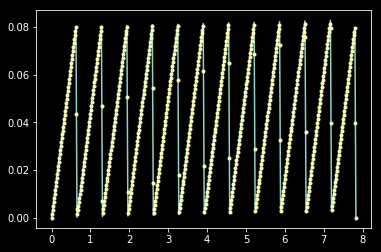

In [81]:
profile_folder = '/pymorph/notebooks/Paper_3/flume_profile_smoothed_v002.txt'
xc, z0 = mgl.readQueensFlume(profile_folder,1)



x = np.linspace(0, 1, 300)
zc = z0.max()*(signal.sawtooth(24*np.pi * x) + 1.)/2
xc = x*xc.max()*3

resolution = 2
f = interp1d(xc, zc)
xnew = np.linspace(0, xc.max(), num=len(xc)*resolution)
znew = f(xnew)
nx = len(xnew)

plt.plot(xc, zc)
plt.plot(xnew, znew,'.')




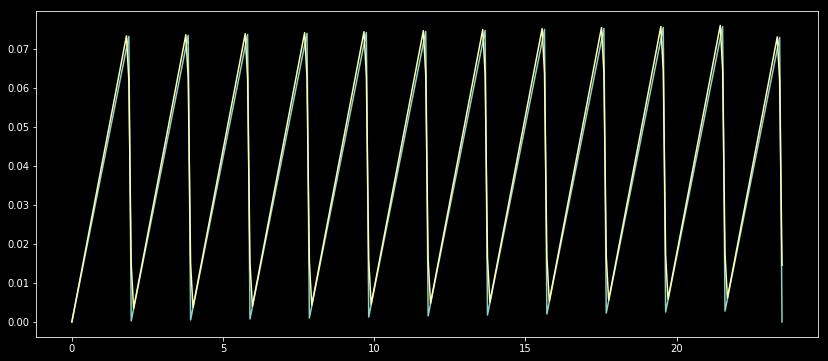

In [69]:
 # Apply the avalanche modelxnew[]
    
fig = plt.figure(figsize=(14, 6))

xsaw = np.linspace(0, 1, 300)
zsaw = 0.076*(signal.sawtooth(24*np.pi * x) + 1.)/2
xsaw = xsaw*xc.max()*3

plt.plot(xsaw,zsaw)

dx = xsaw[1]-xsaw[0]
znew, iterations1 = avalanche_model(dx,xsaw, zsaw, adjustment_angle=28.)
# Now flip it to run in reverse
zflip = np.flip(znew, axis=0)
zflip, iterations1 = avalanche_model(dx,xsaw, zflip, adjustment_angle=28.)
znew = np.flip(zflip, axis=0)

znew = (znew - np.min(znew))/np.ptp(znew)
znew = znew*0.076

plt.plot(xsaw,znew)

ValueError: x and y must have same first dimension, but have shapes (900,) and (300,)

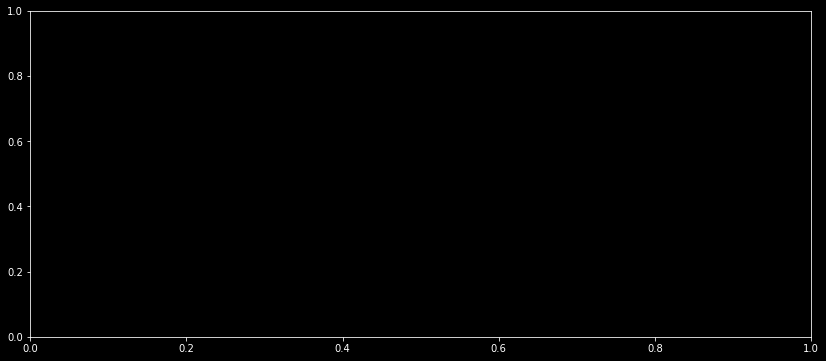

In [68]:
dx = xsaw[1]-xsaw[0]
znew, iterations1 = avalanche_model(dx,xsaw, zsaw, adjustment_angle=28.)
# Now flip it to run in reverse
zflip = np.flip(znew, axis=0)
zflip, iterations1 = avalanche_model(dx,xsaw, zflip, adjustment_angle=28.)
znew = np.flip(zflip, axis=0)

znew = (znew - np.min(znew))/np.ptp(znew)
znew = znew*0.076

fig = plt.figure(figsize=(14, 6))
plt.plot(xnew, znew)
plt.plot(xc, zc)

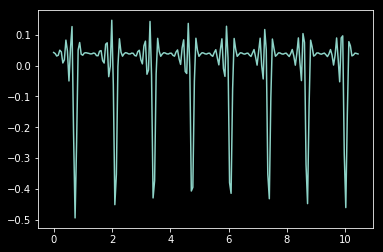

In [16]:
plt.plot(xc,slope)